## Imports

In [1]:
import pickle
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import psutil
import GPUtil

# Define the base path where your pickle file is located
base_path2 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli'
base_path3 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240412-172636'
base_path1_at_same_time = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240413-164417'

In [2]:
# CPU utilization
print(psutil.cpu_percent(interval=1))

# Memory utilization
print(psutil.virtual_memory())

# GPU details (via third-party libraries like GPUtil)
for gpu in GPUtil.getGPUs():
    print("GPU id: {0}, Load: {1}%, Free Memory: {2}MB, Used Memory: {3}MB".format(gpu.id, gpu.load*100, gpu.memoryFree, gpu.memoryUsed))


2.2
svmem(total=1081963773952, available=1032327847936, percent=4.6, used=42702376960, free=372155322368, active=407249108992, inactive=271802851328, buffers=6078451712, cached=661027622912, shared=649199616, slab=24681381888)
GPU id: 0, Load: 100.0%, Free Memory: 70379.0MB, Used Memory: 10670.0MB
GPU id: 1, Load: 95.0%, Free Memory: 71513.0MB, Used Memory: 9536.0MB
GPU id: 2, Load: 98.0%, Free Memory: 71533.0MB, Used Memory: 9516.0MB


## Model Configuration

In [3]:
# Construct the full path to the 'args.pkl' file
args_file_path2 = os.path.join(base_path2, 'args.pkl')

# Load the arguments from the pickle file
with open(args_file_path2, 'rb') as f:
    args2 = pickle.load(f)

# Convert the Namespace to a dictionary if it is of that type
if isinstance(args2, argparse.Namespace):
    args_dict2 = vars(args2)
else:
    print("The loaded 'args' object is not an argparse.Namespace. Its type is:", type(args2))
    exit()

# Determine the maximum width of the argument names for alignment
max_key_length = max(len(key) for key in args_dict2.keys())

# Print the arguments in a structured table format
print(f"{'Argument':<{max_key_length}} | Value")
print("-" * (max_key_length + 3) + "+" + "-" * 30)  # Adjust 30 if you expect wider values

for key, value in args_dict2.items():
    print(f"{key:<{max_key_length}} | {value}")

Argument            | Value
----------------------+------------------------------
data_train          | /home/bosfab01/SpeakerVerificationBA/data/audioset2M_librispeech960.json
data_val            | /home/bosfab01/SpeakerVerificationBA/data/audioset_eval.json
data_eval           | None
label_csv           | /home/bosfab01/SpeakerVerificationBA/data/label_information.csv
n_class             | 527
dataset             | asli
dataset_mean        | -3.6925695
dataset_std         | 4.020388
target_length       | 1024
num_mel_bins        | 128
exp_dir             | ./exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli
lr                  | 0.0001
warmup              | True
optim               | adam
batch_size          | 24
num_workers         | 16
n_epochs            | 9
lr_patience         | 2
adaptschedule       | False
n_print_steps       | 100
save_model          | True
freqm               | 0
timem               | 0
mixup               | 0.0
bal                 | none
fstride   

## Epochs, Iterations and Time Required

### Compare the time required for training the model with 2 and 3 GPUs

In [4]:
# open progress files
with open(os.path.join(base_path2, 'progress.pkl'), 'rb') as f:
    progress2 = pickle.load(f)

with open(os.path.join(base_path3, 'progress.pkl'), 'rb') as f:
    progress3 = pickle.load(f)

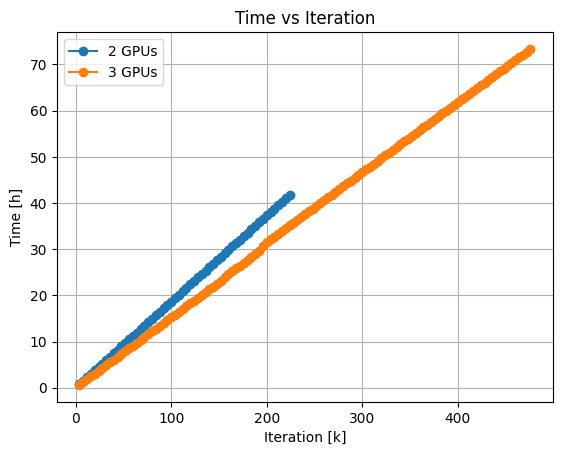

In [5]:
# get the iteration (is at the second position in the list of progress)
iteration2 = np.array([x[1] for x in progress2])

# get the iteration (is at the second position in the list of progress)
iteration3 = np.array([x[1] for x in progress3])

# get time (is at the fourth position in the list of progress)
time2 = np.array([x[3] for x in progress2])

# get time (is at the fourth position in the list of progress)
time3 = np.array([x[3] for x in progress3])


# plot the time vs iteration for the first 20k iterations
plt.plot(iteration2/1e3, time2/3600, "o-", label='2 GPUs')
plt.plot(iteration3/1e3, time3/3600, "o-", label='3 GPUs')
plt.xlabel('Iteration [k]')
plt.ylabel('Time [h]')
plt.title('Time vs Iteration')
plt.grid()
plt.legend()
plt.show()


Fitted line: y = 6.45x + 0.49
Sum of squares of residuals: 323.4699839126379


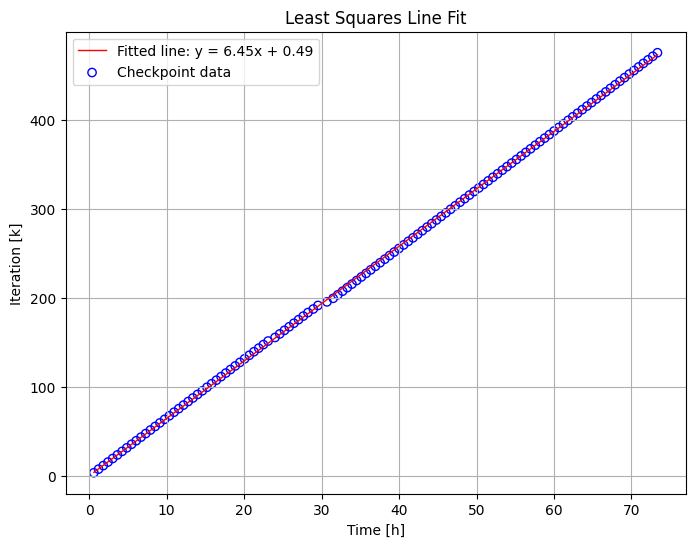

In [6]:
# convert to hours and kilo iterations
time3_h = time3 / 3600
iteration3_k = iteration3 / 1e3

# Step 1: Fit the line
# np.polyfit returns the coefficients [m, q] of the fit y = mx + q
m, q = np.polyfit(time3_h, iteration3_k, 1)

# Step 2: Calculate the predicted values
predicted_iteration3_k = m * time3_h + q

# Step 3: Compute the residuals
residuals = iteration3_k - predicted_iteration3_k

# Step 4: Calculate the sum of the squares of the residuals
sum_of_squares = np.sum(residuals**2)

# Printing the model parameters and the sum of squares
print("Fitted line: y = {:.2f}x + {:.2f}".format(m, q))
print("Sum of squares of residuals:", sum_of_squares)

# Plotting the original data and the fitted line
plt.figure(figsize=(8, 6))
plt.scatter(time3_h, iteration3_k, color='blue', marker='o', facecolors='none', label='Checkpoint data')
plt.plot(time3_h, predicted_iteration3_k, color='red', label=f'Fitted line: y = {m:.2f}x + {q:.2f}', linewidth=1)  # Thinner line
plt.xlabel('Time [h]')
plt.ylabel('Iteration [k]')
plt.title('Least Squares Line Fit')
plt.legend()
plt.grid(True)

# Save the figure as a PDF file
plt.savefig('least_squares_fit.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [7]:
# calculate total time required for all 800k iterations based on the number of iterations and the time per iteration
n_iterations = 800000
time_per_iteration2 = time2[10] / iteration2[10]
time_per_iteration3 = time3[10] / iteration3[10]

total_time2 = time_per_iteration2 * n_iterations
total_time3 = time_per_iteration3 * n_iterations

print(f"Total time for 2 GPUs: {total_time2/3600:.2f} hours")
print(f"Total time for 3 GPUs: {total_time3/3600:.2f} hours")

Total time for 2 GPUs: 149.34 hours
Total time for 3 GPUs: 121.77 hours


## Training and Evaluation Loss

In [8]:
# Construct the full path to the 'result.csv' file
result_file_path3 = os.path.join(base_path3, 'result.csv')

# Load the result from the csv file
result3 = np.genfromtxt(result_file_path3, delimiter=',')

# Extract the columns from the result
acc_train3 = result3[:, 0] # The first column
loss_train3 = result3[:, 1] # The second column
acc_eval3 = result3[:, 2] # The third column
mse_eval3 = result3[:, 3] # The fourth column

# Define the format for each column
header_format = " {:>5}  | {:<10} | {:<10} | {:<10} | {:<10}"
row_format = "{:>5}k  | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f}"

# Print the table headers
print(header_format.format("iter", "acc_train", "loss_train", "acc_eval", "mse_eval"))
print("-" * 60)  # Adjust the total length to fit your headers and column data

  iter  | acc_train  | loss_train | acc_eval   | mse_eval  
------------------------------------------------------------


### compare the training and evaluation loss for the model trained with 2 and 3 GPUs

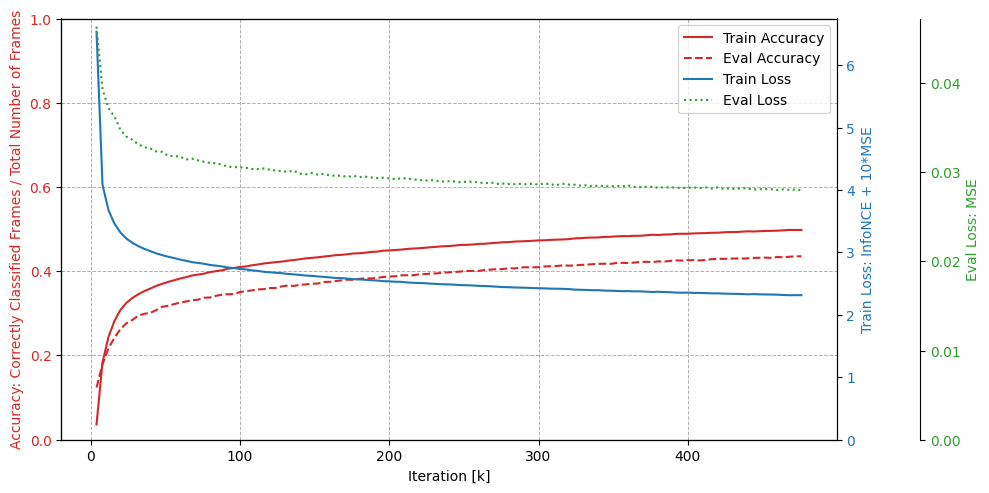

In [9]:
# Create a plot with a wider figure size
fig, ax1 = plt.subplots(figsize=(10, 5))  # You can adjust the size as needed

color_train = 'tab:red'
ax1.set_xlabel('Iteration [k]')
ax1.set_ylabel('Accuracy: Correctly Classified Frames / Total Number of Frames', color=color_train)
line5, = ax1.plot(iteration3 / 1e3, acc_train3, color=color_train, label='Train Accuracy')
line6, = ax1.plot(iteration3 / 1e3, acc_eval3, color=color_train, linestyle='dashed', label='Eval Accuracy')
ax1.tick_params(axis='y', labelcolor=color_train)
ax1.set_ylim(0, 1)  # Set the limit for the accuracy axis starting at 0

ax2 = ax1.twinx()
color_loss = 'tab:blue'
ax2.set_ylabel('Train Loss: InfoNCE + 10*MSE', color=color_loss)
line7, = ax2.plot(iteration3 / 1e3, loss_train3, color=color_loss, label='Train Loss')
ax2.tick_params(axis='y', labelcolor=color_loss)
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start y-axis at 0 for loss

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
color_eval_loss = 'tab:green'
ax3.set_ylabel('Eval Loss: MSE', color=color_eval_loss)
line8, = ax3.plot(iteration3 / 1e3, mse_eval3, color=color_eval_loss, linestyle='dotted', label='Eval Loss')
ax3.tick_params(axis='y', labelcolor=color_eval_loss)
ax3.set_ylim(0, ax3.get_ylim()[1])  # Start y-axis at 0 for eval loss

# Adding grid to the primary axis (ax1)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)

# Collect all lines and labels for the legend
lines = [line5, line6, line7, line8]
labels = [line.get_label() for line in lines]

# Place a single legend on the plot
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.show()

## running another experiment on GPU 1 (from indices 0 to 2)